<a href="https://colab.research.google.com/github/elliemci/vision-transformer-models/blob/main/object_detection/crack_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q datasets transformers

In [ ]:
!pip install evaluate timm albumentations

In [ ]:
!pip install accelerate -U

In [ ]:
!pip install huggingface_hub

In [ ]:
!pip install roboflow

In [ ]:
!pip install roboflow2huggingface

In [5]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/ColabNotebooks/ExplainableAI/object_detection

Mounted at /content/drive
/content/drive/MyDrive/ColabNotebooks/ExplainableAI/object_detection


# Crack Detection with Conditional DETR

Conditional DETR presents a conditional cross-attention mechanism for fast DETR training. it "learns a conditional spatial query from the decoder embedding for decoder multi-head cross-attention. The benefit is that through the conditional spatial query, each cross-attention head is able to attend to a band containing a distinct region, e.g., one object extremity or a region inside the object box. This narrows down the spatial range for localizing the distinct regions for object classification and box regression."

## 1. Import a Roboflow dataset into Hugging Face

Load a Roboflow building cracks images dataset and convert to Hugging Face object detection and fine tune a variant of DETR, [conditional DETR](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/2108.06152), which combines a convolutional backbone with an encoder-decoder Transformer. Using images from surveillance cameras, the model identifies the presence of cracks and can estimate building construction quality and risks.

In [ ]:
from huggingface_hub import create_repo

# create a repository on Huggingface account
create_repo(repo_id="elliemci/building_cracks", repo_type="dataset", private=False)

In [ ]:
from roboflow2huggingface import roboflow_to_huggingface_pipeline
from google.colab import userdata

userdata.get('roboflow_api_key')
userdata.get('huggingface_hub_access_token')

rf_api_key = input('Enter your Roboflow API key: ')
hf_token = input('Enter your Hugging Face write token: ')

# create a project on Roboflow, connect to a building cracks dataset on Roboflow
# and export dataset to Hugging Face dataset account
roboflow_to_huggingface_pipeline(
    roboflow_universe_url = 'https://universe.roboflow.com/crack-7rsjb/crack-detection-ol3yi/dataset/1',
    roboflow_api_key = rf_api_key,  #'roboflow_api_key',
    hf_dataset_id = 'elliemci/building_cracks',
    hf_write_token = hf_token #'huggingface_hub_access_token'
)

## 2. Load dataset from Hugging Face

In [ ]:
import os

from google.colab import userdata
from datasets import load_dataset
from huggingface_hub import login

userdata.get('huggingface_hub_access_token')
login()

#os.environ["HF_TOKEN"] = "your_access_token"
userdata.get('HF_TOKEN')

ds = load_dataset("elliemci/building_cracks", name="full", trust_remote_code=True)

In [7]:
ds

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1673
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 477
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 244
    })
})

In [17]:
# the feature metadata of the object column in the split contains the vehichle's categories
print(f"dataset categories: {ds['train'].features['objects'].feature['category'].names}")

dataset categories: ['crack']


In [18]:
# get unique category IDs
unique_category_ids = set()
for split in ds:  # iterate through 'train', 'test'
    for example in ds[split]:
        unique_category_ids.update(example['objects']['category'])

# create mappings between category indices and labels
id2label = {
    i: feature
    for i, feature in enumerate(ds['train'].features['objects'].feature['category'].names)}
label2id = {v: k for k, v in id2label.items()}

print(f"ids to labels mapping: {id2label}")
print(f"labels to ids mapping: {label2id}")
print()
# print category names
print("Object Category Names:")
for category_id in unique_category_ids:
    category_name = id2label.get(category_id, "Unknown")  # handle unknown IDs
    print(f"- {category_name}")

ids to labels mapping: {0: 'crack'}
labels to ids mapping: {'crack': 0}

Object Category Names:
- crack


In [35]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def display_annotated_image(example, id2label):
  # display image with detected object category names
  print()
  plt.imshow(example['image'])
  plt.axis("off")

  # draw bounding boxes and category labels
  ax = plt.gca()

  # a loop though each detected object bounding box
  for i in range(len(example['objects']['bbox'])):
    bbox = example['objects']['bbox'][i]
    x, y, w, h = bbox
    rect = Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')

    ax.add_patch(rect)
    category_id = example['objects']['category'][i]
    category_name = id2label.get(category_id, "Unknown")
    plt.text(x, y, category_name, color='r', fontsize=12)

plt.show()

sample content:
image_id: 873
image: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=200x200 at 0x78739F2EB410>
width: 200
height: 200
objects: {'id': [874], 'area': [13333], 'bbox': [[61.0, 0.0, 67.0, 199.0]], 'category': [0]}


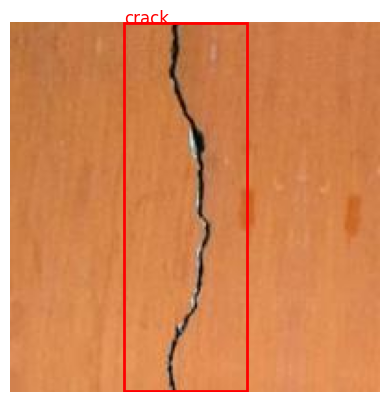

In [34]:
import random

rand_inx = random.randint(0, len(ds["train"]) - 1)
example = ds['train'][rand_inx]

# display example content
print(f"sample content:")
for key, value in example.items():
    print(f"{key}: {value}")

display_annotated_image(example, id2label)

## 3. Pre-process dataset

### Resize and augment

In [19]:
import albumentations as A

transform = A.Compose([
    A.Resize(480, 480),
    A.HorizontalFlip(p=0.5), # 50% chanse of horizontal flip to be applied to an image
    A.RandomBrightnessContrast(p=1.0), # 100% i.e. all images will have their brightness and contrast randomly adjusted
], bbox_params=A.BboxParams(format='coco', label_fields=['category']))

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### Format annotations into COCO-compatible

In [20]:
def format_annot(image_id, categories, areas, bboxes):
  """ Format annotations into COCO format of a given image with image_id, list of category ids
      list of area ids, and a list of bounding boxes, returning a formatied list of annotations."""

  annotations = []

  for i in range(0, len(categories)):
    new_ann = {
            "image_id": image_id,
            "category_id": categories[i],
            "isCrowd": 0,
            "area": areas[i],
            "bbox": list(bboxes[i]),
        }
    annotations.append(new_ann)

  return annotations

### Load Conditional Transformer

### Instantiate Image Processor

Image processor is in charge of preparing vision models input features and post processing their outputs. This includes transformations such as resizing, normalization, and conversion. Since the architecture can be guessed from the path of the pretrained model suplied to the from_pretrained() an AutoClasses can be used.

In [21]:
from transformers import AutoImageProcessor

checkpoint = "microsoft/conditional-detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

preprocessor_config.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

### Pass images and annotations lists through Image Processor

In [24]:
import numpy as np

def transform_augment(example):
  """ The function takes an example dictionary as input, which contains image data
      and object annotations, and it transformes them with a pre-defined transform
      function, iterating through each image and formatting annotations in the example."""

  image_id = example['image_id']
  images, bboxes, areas, categories = [], [], [], []

  for image, objects  in zip(example["image"], example["objects"]):
    # convert the image to RGB and reverse the color channel
    image = np.array(image.convert("RGB"))[:, :, ::-1]
    # aplly transformation to the image
    out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])
    # append transformed and augmented data to the respective lists
    areas.append(objects["area"])
    images.append(out["image"])
    bboxes.append(out["bboxes"])
    categories.append(out["category"])
  # use list comprehention to iterate through the lists to format the annotations
  targets = [
        {"image_id": id,
         "annotations": format_annot(id, cat, ar, box)}
        for id, cat, ar, box in zip(image_id, categories, areas, bboxes)
  ]
  # pre-process with image_processor
  example = image_processor(images=images, annotations=targets, return_tensors="pt")

  return example

In [25]:
# modify in place vs ds['train']=ds['train'].with_transform(transform_augment)
ds['train'].set_transform(transform_augment)
print(f"transformed and augmented image: {ds['train'][0]}")

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


original image: {'pixel_values': tensor([[[1.2557, 1.2557, 1.2557,  ..., 1.4440, 1.4440, 1.4440],
         [1.2557, 1.2557, 1.2557,  ..., 1.4440, 1.4440, 1.4440],
         [1.2557, 1.2557, 1.2557,  ..., 1.4440, 1.4440, 1.4440],
         ...,
         [1.1358, 1.1358, 1.1358,  ..., 1.1187, 1.1187, 1.1187],
         [1.1358, 1.1358, 1.1358,  ..., 1.1187, 1.1187, 1.1187],
         [1.1358, 1.1358, 1.1358,  ..., 1.1187, 1.1187, 1.1187]],

        [[1.7108, 1.7108, 1.7108,  ..., 1.8859, 1.8859, 1.8859],
         [1.7108, 1.7108, 1.7108,  ..., 1.8859, 1.8859, 1.8859],
         [1.7108, 1.7108, 1.7108,  ..., 1.8859, 1.8859, 1.8859],
         ...,
         [1.6583, 1.6583, 1.6583,  ..., 1.6933, 1.6933, 1.6933],
         [1.6583, 1.6583, 1.6583,  ..., 1.6933, 1.6933, 1.6933],
         [1.6583, 1.6583, 1.6583,  ..., 1.6933, 1.6933, 1.6933]],

        [[2.2391, 2.2391, 2.2391,  ..., 2.4134, 2.4134, 2.4134],
         [2.2391, 2.2391, 2.2391,  ..., 2.4134, 2.4134, 2.4134],
         [2.2391, 2.2391,

## 4. Batch Images and Masks

### Pad Images, Create Pixel Mask and Construct a batch

In [26]:
def collate_func(batch):
  """ Batching the training data preparing it in format expected by the model.
  It handles padding images, creates pixel masks."""

  # extract the pizel values and the ground truth annoataions
  pixel_values = [item['pixel_values'] for item in batch]
  labels = [item['labels'] for item in batch]
  # use image procesor to pad and create a pixel mask
  encoding = image_processor.pad(pixel_values, return_tensors="pt")
  # extract labels from each item in the batch
  labels = [item["labels"] for item in batch]

  batch = {}
  # combine image data, pixel masks, and labels into a single dictionary
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels

  return batch

## 5. Train conditional DETR model

### Load model

In [27]:
from transformers import ConditionalDetrForObjectDetection # AutoModelForObjectDetection

model = ConditionalDetrForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

config.json:   0%|          | 0.00/4.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/174M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of ConditionalDetrForObjectDetection were not initialized from the model checkpoint at microsoft/conditional-detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([1]) in the model instantiated
- class_labels_classifier.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([1, 256]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Define hyperparameters

In [30]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir = "building-cracks",
    per_device_train_batch_size = 8,
    num_train_epochs = 10,
    fp16 = True,
    save_steps = 20,
    logging_steps = 10,
    learning_rate = 1e-5,
    weight_decay = 1e-4,
    save_total_limit = 2,
    remove_unused_columns = False,
    push_to_hub = True,
    #hub_token =
)

### Pass training arguments

In [31]:
from transformers import Trainer # high-level API for training pytorch models

trainer = Trainer(
    model = model,
    args = training_args,
    data_collator = collate_func,
    train_dataset = ds["train"],
    tokenizer = image_processor,
)

<ipython-input-31-ecc3ef446ca3>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### Train

In [33]:
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import accelerate

# Create a DataLoader for training dataset
train_dataloader = DataLoader(
    ds["train"],
    batch_size = trainig_args.per_device_train_batch_size,
    collate_fn = collate_func,
)

# Initialize the accelerator
accelerator = accelerate.Accelerator(mixed_precision='fp16')

# Prepare the model, optimizer, and dataloader for distributed training
model, optimizer, train_dataloader = accelerator.prepare(
    model, torch.optim.AdamW(model.parameters(), lr=trainig_args.learning_rate), train_dataloader
)

# Training loop
for epoch in range(trainig_args.num_train_epochs):
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}")

    for batch in progress_bar:
        # Move data to the appropriate device
        pixel_values = batch["pixel_values"].to(accelerator.device)
        pixel_mask = batch["pixel_mask"].to(accelerator.device)
        labels = [{k: v.to(accelerator.device) for k, v in t.items()} for t in batch["labels"]]

        # Forward pass
        outputs = model(pixel_values, pixel_mask=pixel_mask, labels=labels)
        loss = outputs.loss

        # Backward pass and optimization
        accelerator.backward(loss)
        optimizer.step()
        optimizer.zero_grad()

        # Update progress bar
        progress_bar.set_postfix(loss=loss.item())

    # Save the model at the end of each epoch
    if trainig_args.should_save:
        accelerator.wait_for_everyone()
        unwrapped_model = accelerator.unwrap_model(model)
        unwrapped_model.save_pretrained(trainig_args.output_dir, save_function=accelerator.save)

Epoch 1:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/210 [00:00<?, ?it/s]

In [34]:
model.save_pretrained("condDetr_crack_detection")
# save the image processor configuration to model directory
image_processor.save_pretrained("condDetr_crack_detection")

['condDetr_crack_detection/preprocessor_config.json']

### Upload trained model to Hugging Face Hub

In [36]:
model.push_to_hub(repo_id="elliemci/condDetr_crack_detection")

model.safetensors:   0%|          | 0.00/174M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/elliemci/condDetr_crack_detection/commit/9d97212100e46723785930622f9003a702c6f7a8', commit_message='Upload ConditionalDetrForObjectDetection', commit_description='', oid='9d97212100e46723785930622f9003a702c6f7a8', pr_url=None, repo_url=RepoUrl('https://huggingface.co/elliemci/condDetr_crack_detection', endpoint='https://huggingface.co', repo_type='model', repo_id='elliemci/condDetr_crack_detection'), pr_revision=None, pr_num=None)

## 6. Inference

In [8]:
from transformers import ConditionalDetrForObjectDetection, AutoImageProcessor

trained_model = ConditionalDetrForObjectDetection.from_pretrained("condDetr_crack_detection")
image_processor = AutoImageProcessor.from_pretrained("condDetr_crack_detection")

id2label = trained_model.config.id2label
label2id = trained_model.config.label2id

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

### Load Random Image

In [62]:
import random

# slect a random test image
rand_idx = random.randint(0, len(ds["test"]) - 1)

image = ds["test"][rand_idx]["image"]
# ground truth bounding boxes for objects in image
box_gt =  ds["test"][rand_idx]["objects"]["bbox"]
box_gt = [item for sublist in box_gt for item in sublist]

#image = ds["test"][230]["image"]
#box_gt =  ds["test"][230]["objects"]["bbox"]
#box_gt = [item for sublist in box_gt for item in sublist]

### Perform Inference

In [67]:
import torch
import requests

# perform inference on input image
with torch.no_grad():
  # preprocess the image
  inputs = image_processor(images=image, return_tensors="pt")
  # forward pass through the object detection
  outputs = trained_model(**inputs)
  # set terget size for postprocessing
  target_sizes = torch.tensor([image.size[::-1]])
  # post-process the outputs
  results = image_processor.post_process_object_detection(
      outputs,
      threshold = 0.4,
      target_sizes = target_sizes)[0]

# print the detected objects with confidence score and bounding boxes coordinates
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
  box = [round(i, 2) for i in box.tolist()]
  print(
      f"Detected {trained_model.config.id2label[label.item()]} with confidence "
      f"{round(score.item(), 3)} at location {box}"
  )

Detected crack with confidence 0.419 at location [62.71, -0.98, 199.04, 198.31]


In [68]:
results

{'scores': tensor([0.4186]),
 'labels': tensor([0]),
 'boxes': tensor([[ 62.7124,  -0.9793, 199.0407, 198.3085]])}

### Display image

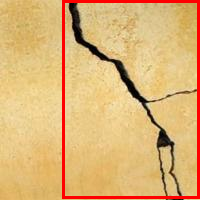

In [69]:
# create a drawing object  draw = ImageDraw.Draw(image) to visualize the detection results on the input image
from PIL import ImageDraw

draw = ImageDraw.Draw(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x_min, y_min, x_max, y_max = box
    draw.rectangle([(x_min, y_min), (x_max, y_max)], outline="red", width=3)  # draw bounding box
    draw.text((x_min, y_min - 15), f"{id2label[label.item()]} ({round(score.item(), 2)})", fill="red") # add label and confidence

image

## 7. Evaluate

### Mean IoU for Object Detection

In [70]:
from shapely.geometry import Polygon

def calculate_iou(box_1, box_2):

    poly_1 = Polygon(box_1)
    poly_2 = Polygon(box_2)
    iou = poly_1.intersection(poly_2).area/poly_1.union(poly_2).area

    return iou

In [71]:
x, y, x2, y2 = tuple(box)
xgt, ygt, x2gt, y2gt = tuple(box_gt)

box_1 = [[x, y], [x2, y], [x2, y2], [x, y2]]
box_2 = [[xgt, ygt], [x2gt, ygt], [x2gt, y2gt], [xgt, y2gt]]

iou= calculate_iou(box_1, box_2)

### Estimate mean IoU for prediction

In [72]:
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]

    x, y, x2, y2 = tuple(box)
    xgt, ygt, x2gt, y2gt = tuple(box_gt)

    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.rectangle((xgt, ygt, x2gt, y2gt), outline="green", width=1)
    draw.text((x, y), "preddicted", fill="red")
    draw.text((x2gt, y2gt), "ground truth", fill="green")

(-0.5, 199.5, 199.5, -0.5)

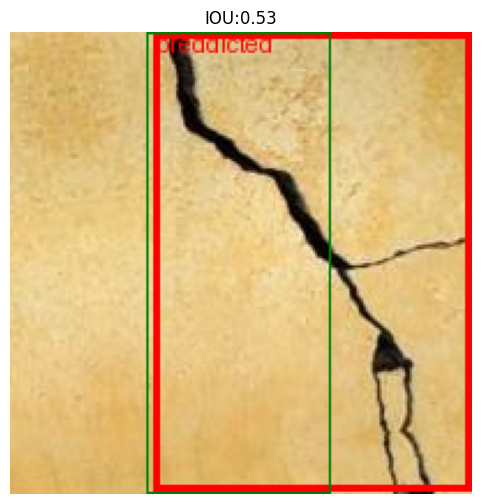

In [75]:
from matplotlib import pyplot as plt

draw = ImageDraw.Draw(image)

fig = plt.figure(figsize=(6, 6))

plt.imshow(image)
plt.title(f"IOU:{str(round(iou, 2))}")
plt.axis("off")